In [4]:
# for backtest and loading data
from finmarketpy.backtest import BacktestRequest, Backtest
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator
from findatapy.util.fxconv import FXConv
from finmarketpy.economics import TechIndicator, TechParams
from findatapy.util.loggermanager import LoggerManager
from chartpy import Chart, Style
logger = LoggerManager().getLogger(__name__)
import datetime

In [7]:
# pick USD crosses in G10 FX
# note: we are calculating returns from spot (it is much better to use to total return
# indices for FX, which include carry)
logger.info("Loading asset data...")

tickers = ['EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 'USDCAD',
           'NZDUSD', 'USDCHF', 'USDNOK', 'USDSEK']

vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DEXUSUK', 'FRED/DEXUSAL', 'FRED/DEXCAUS',
                  'FRED/DEXUSNZ', 'FRED/DEXSZUS', 'FRED/DEXNOUS', 'FRED/DEXSDUS']

md_request = MarketDataRequest(
    start_date="01 Jan 1989",  # start date
    finish_date=datetime.date.today(),  # finish date
    freq='daily',  # daily data
    data_source='quandl',  # use Quandl as data source
    tickers=tickers,  # ticker (findatapy)
    fields=['close'],  # which fields to download
    vendor_tickers=vendor_tickers,  # ticker (Quandl)
    vendor_fields=['close'],  # which Bloomberg fields to download
    cache_algo='internet_load_return')  # how to return data

market = Market(market_data_generator=MarketDataGenerator())

asset_df = market.fetch_market(md_request)
spot_df = asset_df

2020-11-10 19:41:56,907 - __main__ - INFO - Loading asset data...
2020-11-10 19:41:57,585 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-10 19:41:57,596 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-10 19:41:57,596 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-10 19:41:57,596 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-10 19:44:10,594 - findatapy.market.datavendorweb - INFO - Completed request from Quandl for ['EURUSD.close']
2020-11-10 19:44:10,596 - findatapy.market.datavendorweb - INFO - Request Quandl data
2020-11-10 19:44:26,939 - findatapy.market.datavendorweb - INFO - Attempting... 1 request to download from Quandl due to following error: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.
2020-11-10 19:44:26,941 - findat

In [8]:
backtest = Backtest()
br = BacktestRequest()
fxconv = FXConv()

# get all asset data
br.start_date = "02 Jan 1990"
br.finish_date = datetime.datetime.utcnow()
br.spot_tc_bp = 0  # 2.5 bps bid/ask spread
br.ann_factor = 252

# have vol target for each signal
br.signal_vol_adjust = True
br.signal_vol_target = 0.05
br.signal_vol_max_leverage = 3
br.signal_vol_periods = 60
br.signal_vol_obs_in_year = 252
br.signal_vol_rebalance_freq = 'BM'
br.signal_vol_resample_freq = None

tech_params = TechParams();
tech_params.bb_period = 200;
tech_params.bb_mult = 0.5 ;
indicator = 'BB'

logger.info("Running backtest...")

# use technical indicator to create signals
# (we could obviously create whatever function we wanted for generating the signal dataframe)
tech_ind = TechIndicator()
tech_ind.create_tech_ind(spot_df, indicator, tech_params);
signal_df = tech_ind.get_signal()

contract_value_df = None

# use the same data for generating signals
backtest.calculate_trading_PnL(br, asset_df, signal_df, contract_value_df, run_in_parallel=False)
port = backtest.portfolio_cum()
port.columns = [indicator + ' = ' + str(tech_params.sma_period) + ' ' + str(backtest.portfolio_pnl_desc()[0])]
signals = backtest.portfolio_signal()

# print the last positions (we could also save as CSV etc.)
print(signals.tail(1))

2020-11-10 19:49:02,713 - __main__ - INFO - Running backtest...
2020-11-10 19:49:02,753 - finmarketpy.backtest.backtestengine - INFO - Calculating trading P&L...
2020-11-10 19:49:02,801 - finmarketpy.backtest.backtestengine - INFO - Cumulative index calculations
2020-11-10 19:49:02,811 - finmarketpy.backtest.backtestengine - INFO - Completed cumulative index calculations
            EURUSD.close BB Signal  USDJPY.close BB Signal  \
Date                                                         
2020-11-06                 0.08321               -0.102708   

            GBPUSD.close BB Signal  AUDUSD.close BB Signal  \
Date                                                         
2020-11-06                0.062994                0.060006   

            USDCAD.close BB Signal  NZDUSD.close BB Signal  \
Date                                                         
2020-11-06               -0.093499                0.057194   

            USDCHF.close BB Signal  USDNOK.close BB Signal  \
Dat

<ipython-input-8-6ed10411f152>:30: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



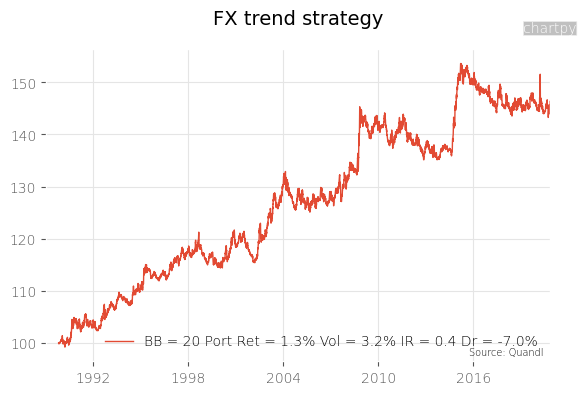

In [9]:
style = Style()
style.title = "FX trend strategy"
style.source = 'Quandl'
style.scale_factor = 1
style.file_output = 'fx-trend-example.png'

Chart().plot(port, style=style)